# Synthetic sea surface elevation from CDIP directional wave spectrum

Author: Bia Villas Bôas - avillasboas@ucsd.edu

This notebook takes the most spectral data from [CDIP buoy 185](http://cdip.ucsd.edu/m/products/?stn=185p1) (Monterey Bay) and constructs a synthetic realization of the corresponding sea surface using superposition of linear waves and random phases. It uses the auxiliary functions `plot_dirSpec` and  `getmem`, both available in this repository.

In [1]:
from IPython.display import clear_output, HTML

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, cm
from matplotlib.animation import FuncAnimation
from netCDF4 import Dataset, num2date

from getmem import GetMem
from plot_dirSpec import  plot_dirSpec

Here, we read the directional spectrum data directly from CDIP's website via OPeNDAP.

In [2]:
nc = Dataset('http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/realtime/185p1_rt.nc')

We will use the most recent time (last value in the time dimension)

In [3]:
ts = -1 # timestamp
nctime = nc.variables['waveTime'][:][ts]
print("The most recent time is:", num2date(nctime, units=nc.variables['waveTime'].units))

The most recent time is: 2022-01-14 21:30:00


Now, we read the frequencies and energy spectrum 

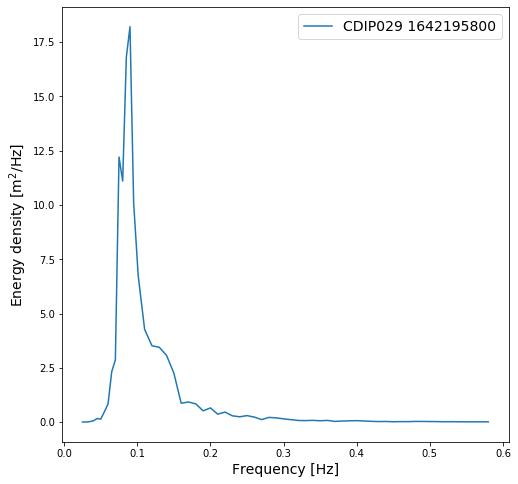

In [4]:
freq = nc.variables['waveFrequency'][:] # wave frequency
energy = nc.variables['waveEnergyDensity'][:][ts]

plt.figure(figsize=(8,8))
plt.plot(freq, energy, label='CDIP029 {0}'.format(nctime))
plt.ylabel("Energy density [m$^2$/Hz]", fontsize=14)
plt.xlabel("Frequency [Hz]", fontsize=14)
plt.legend(fontsize=14)

Operational wave buoys do not save the entire frequency-direction information. Instead, wave buoys usually save the first four directional Fourier coefficients. Here we use the Maximum Entropy Method to reconstruct the directional spectrum from the coefficients (see [Lygre et. al, 1986](https://journals.ametsoc.org/jpo/article/16/12/2052/6574) ).

In [5]:
a1 = nc.variables['waveA1Value'][:][ts]
b1 = nc.variables['waveB1Value'][:][ts]
a2 = nc.variables['waveA2Value'][:][ts]
b2 = nc.variables['waveB2Value'][:][ts]

Before reconstructing the spectrum let's check some of the bulk wave parameters computed by CDIP:

In [6]:
print("Peak wave direction:", nc.variables['waveDp'][:][ts])
print("Peak wave period:", nc.variables['waveTp'][:][ts])
print("Significant wave height:", nc.variables['waveHs'][:][ts])

Peak wave direction: 302.6875
Peak wave period: 11.111111
Significant wave height: 3.23


Now we reconstruct and plot the directional spectrum

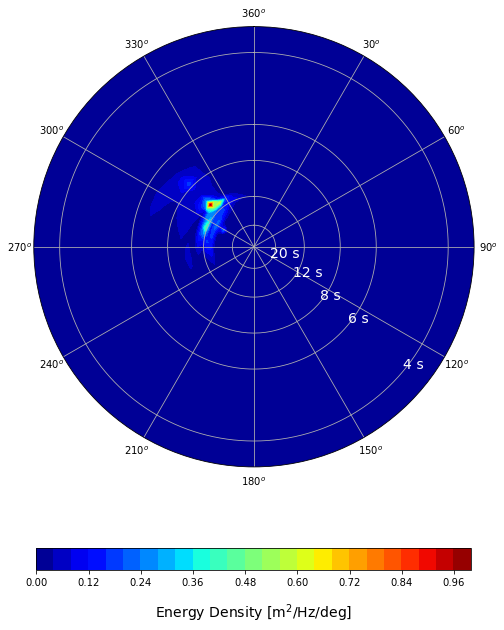

In [7]:
ndir = 48 # number of direction bins
E = np.tile(energy, (ndir,1)).T
norm_mem= GetMem(a1,b1,a2,b2, ndir=ndir) # This uses the auxiliary function GetMem
dirSpec = E*norm_mem
dirSpec = dirSpec.T
plot_dirSpec(dirSpec, freq, directions=None, vmin=0,filename=None) # This uses the auxiliary function plot_dirSpec

We can check the significant wave height by computing:
$$H_s = 4 \left[\int_{0^\circ}^{360^\circ} \int_0^\infty  E(f,\theta) df d\theta\right]^{1/2}
$$ 



In [8]:
df = nc.variables['waveFrequencyBounds'][:,1] - nc.variables['waveFrequencyBounds'][:,0]
ndir, nfreq = dirSpec.shape
dth = 360/ndir # delta theta in degrees
directions = np.arange(0, 360, dth)
dir_rad = np.radians(directions)

hs_reconstruct = 4*(np.sum(np.dot(dirSpec, df)*dth))**.5
print("The significan wave height from the directional spectrum is: {0}m".format(
    round(hs_reconstruct,2)))

The significan wave height from the directional spectrum is: 3.27m


Now, we assume the linear deep-water dispersion relationto compute the wavenumbers:

$$
\sigma^2 = g k
$$

In [9]:
g = 9.81
sig = 2*np.pi*freq # going from linear freq to angular
k = sig**2/g
lmax = 2*np.pi/k.min()
lmin = 2*np.pi/k.max()
print("max resolved wavelength = {0}m".format(lmax))
print("min resolved wavelength = {0}m".format(lmin))

max resolved wavelength = 2498.0958768706773m
min resolved wavelength = 4.641230539935751m


Let's we create a horizontal grid to construct ou synthetic sea surface.

In [10]:
L = 2000 # domain length
dx = 5 #grid spacing in x
x = np.arange(0,lmax, dx)
y = x
xx, yy = np.meshgrid(x, y)
print('If the units of x is meters, the grid spacing is {0} m'.format(round(x[1]-x[0]),2))
print('If the units of x is meters, the grid goes from {0} m to {1} m'.format(x[0], x[-1]))

If the units of x is meters, the grid spacing is 5.0 m
If the units of x is meters, the grid goes from 0.0 m to 2495.0 m


Considering that the sea surface results from the linear superposition of all waves (all frequencies and directions), the surface elevation can be writen as.

$$
\eta(x, y, t) = \sum_i \sum_j A[i, j] \ \cos(k_x[i] x + k_y[i] y + \phi[i, j]),
$$

where the amplitude of the Fourier coefficients  $A[i, j]$ is related to the spectral density by

$$
E(f, \theta) = \frac{1}{\Delta f \Delta \theta} \left< \frac{1}{2} A^2[i, j]\right>
$$

In [11]:
A = (2*dirSpec*df*dth)**.5 # Wave amplitudes from spectral densities

In [12]:
zeta = np.zeros(xx.shape)
E = 0
for i in range(ndir):
    for j in range(nfreq):
        kx = k[j]*np.cos(dir_rad[i]+np.pi)
        ky = k[j]*np.sin(dir_rad[i]+np.pi)
        phi = np.random.random()*2*np.pi # random phases
        zeta += A[i,j] * np.cos(kx*xx + ky*yy + phi) 

In [13]:
print("Hs computed from the synthetic sea surface elevation: {0}".format(4*(zeta).std()))

Hs computed from the synthetic sea surface elevation: 3.2778616101226064


Text(0.5, 1.0, 'Sea Surface Elevation')

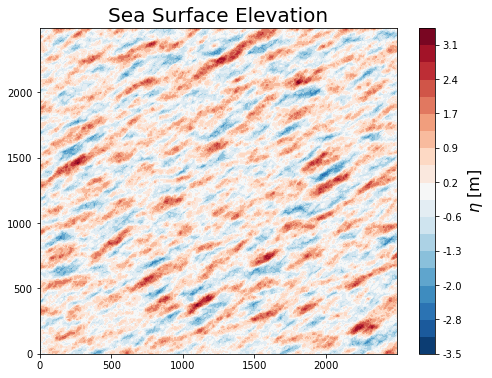

In [14]:
clim = np.max(abs(zeta))
lin = np.linspace(-clim, clim, 20)
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, zeta, lin, cmap = 'RdBu_r')
cbar = plt.colorbar(format='%.1f')
cbar.set_label('$\eta$ [m]', fontsize=16)
plt.title("Sea Surface Elevation", fontsize=20)

Now, we could have propagating waves if we add the frequency to the phase


$$
\eta(x, y, t) = \sum_i \sum_j A[\theta_i, \sigma_j] \ cos(k_x[i] x + k_y[i] y + \phi[i, j] + \sigma[j]t)
$$


This will probably take a while to run

In [15]:
# g = 9.81
# sig = 2*np.pi*freq # going from linear freq to angular
# k = sig**2/g
# lmax = 2*np.pi/k.min()
# lmin = 2*np.pi/k.max()

# L = 2000 # domain length
# dx = 5 #grid spacing in x
# x = np.arange(0,lmax, dx)
# y = x
# xx, yy = np.meshgrid(x, y)

# nt = 20 
# ny, nx = xx.shape
# t = np.linspace(0, np.pi, nt);
# zeta = np.zeros([nt, ny, nx])
# E = np.zeros(nt)
# for n in range(nt):
#     for i in range(ndir):
#         for j in range(nfreq):
#             kx = k[j]*np.cos(dir_rad[i]+np.pi)
#             ky = k[j]*np.sin(dir_rad[i]+np.pi)
#             phi = np.random.random()*2*np.pi # random phases
#             zeta[n] += A[i,j]*np.cos(kx*xx + ky*yy + phi + sig[j]*t[n])
#             E[n] += A[i,j]**2

In [16]:
# def animate(i):
#     ax.contourf(xx, yy, zeta[i], lin, cmap='RdBu_r')

# fig, ax = plt.subplots(figsize=(8, 6))
# cs = ax.contourf(xx, yy, zeta[0], lin, cmap='RdBu_r')
# fig.colorbar(cs, format='%.1f')

# anim = FuncAnimation(
#     fig, animate, interval=200, frames=20)

In [17]:
# rc('animation', html='html5')
# HTML(anim.to_html5_video())